In [1]:
#Импортируем необходимые библиотеки

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
from scipy import stats
import statsmodels.api as sm
from itertools import product
from tqdm import tqdm
from decimal import Decimal

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Импортируем необходимые данные
df = pd.read_excel('A1.xlsx', sheet_name='Timeseries', index_col='Date', parse_dates=['Date'])

In [4]:
df.head(15)

,series1
Date,
2015-01-01,1006.699649
2015-01-02,3197.751826
2015-01-03,3217.491035
2015-01-04,2151.573759
2015-01-05,4243.929892
2015-01-06,3178.012617
2015-01-07,1816.007210
2015-01-08,3020.098947
2015-01-09,3671.492837


In [5]:
df.shape

(1642, 1)

<Figure size 1080x504 with 0 Axes>

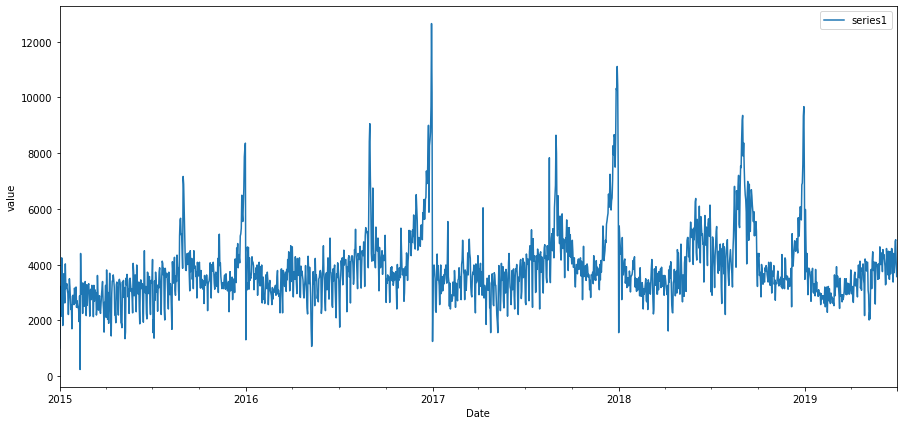

In [6]:
#Отрисовываем полученные данные
plt.figure(figsize(15, 7))
df.plot()
plt.ylabel('value')
plt.show()

# Проверка на стационарность с помощью критерия Дики-Фуллера и графиков тренда, сезонности, остатков

Критерий Дики-Фуллера: p = 0.0000021


<Figure size 1080x576 with 0 Axes>

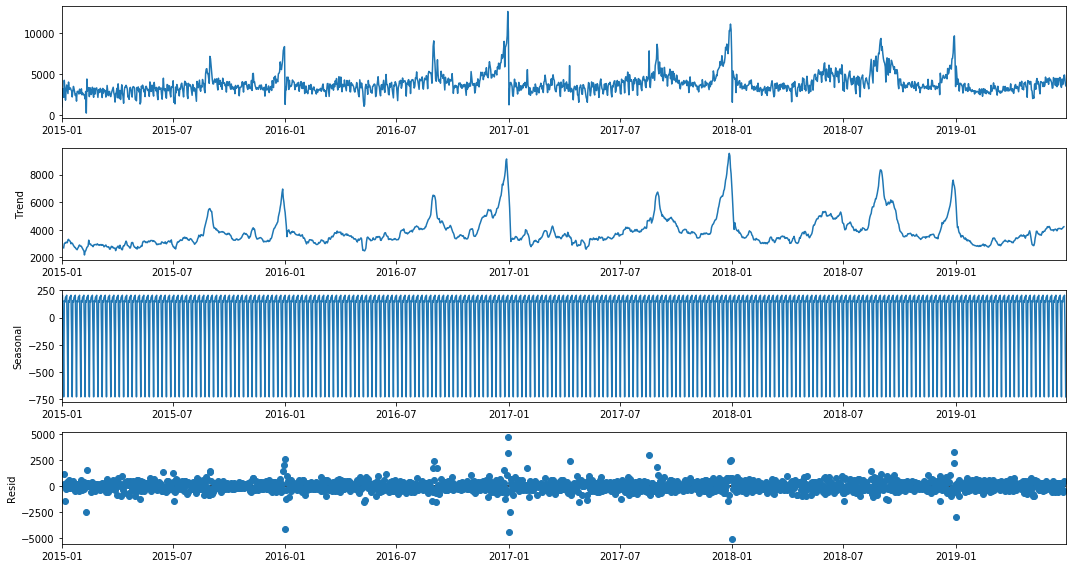

In [7]:
plt.figure(figsize(15, 8))
sm.tsa.seasonal_decompose(df).plot()
print(f'Критерий Дики-Фуллера: p = {round(Decimal(sm.tsa.stattools.adfuller(df)[1]), 7)}')

In [25]:
# Вывод по анализу стационарности
test = sm.tsa.adfuller(df)
print (f'adf: {round(Decimal(test[0]), 7)}')
print (f'p-value: {round(Decimal(test[1]), 7)}')
print (f'Critical values: {test[4]}')
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf: -5.4967138
p-value: 0.0000021
Critical values: {'1%': -3.4343930197503107, '5%': -2.8633257585414, '10%': -2.567720699969517}
Единичных корней нет, ряд стационарен


# Подбор модели

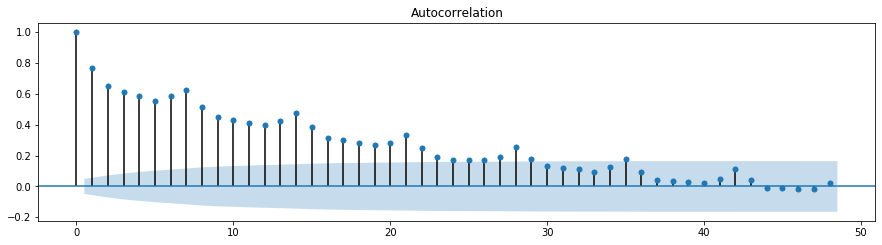

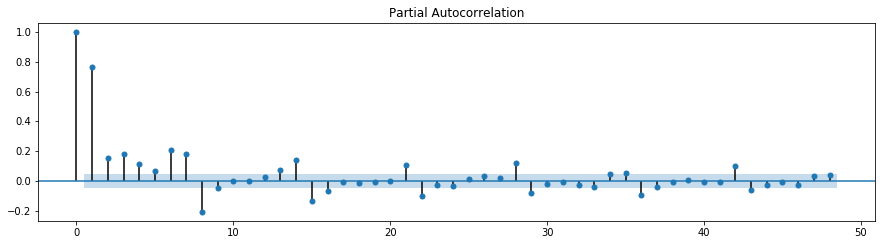

In [26]:
#Построение автокорреляции и частичной автокорреляции
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.series1.values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.series1.values.squeeze(), lags=48, ax=ax)
pylab.show()

Оптимальный параметр Бокса-Кокса = 0.08547892521913668
Критерий Дики-Фуллера: p = 0.0000069


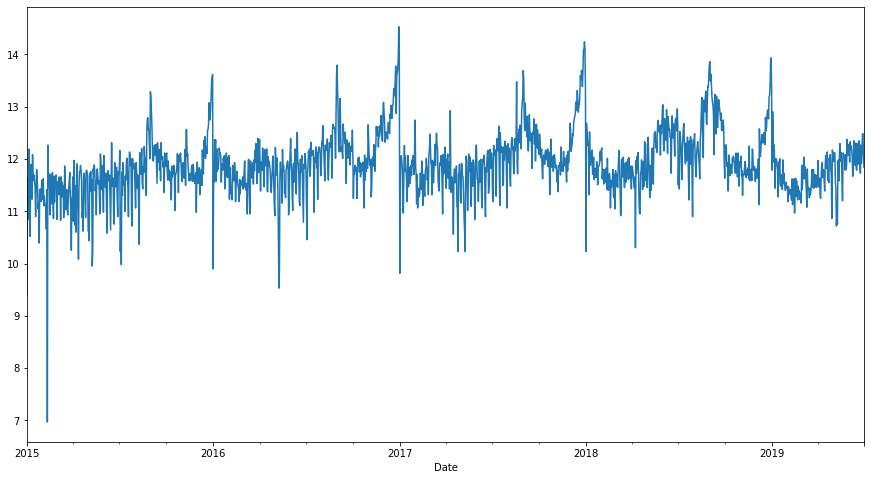

In [27]:
#С учетом большого количества лагов применяем преобразование Бокса-Кокса
df['series1_box'], lmbda = stats.boxcox(df.series1)
df.series1_box.plot()
print(f'Оптимальный параметр Бокса-Кокса = {lmbda}')
print(f'Критерий Дики-Фуллера: p = {round(Decimal(sm.tsa.stattools.adfuller(df.series1_box)[1]), 7)}')

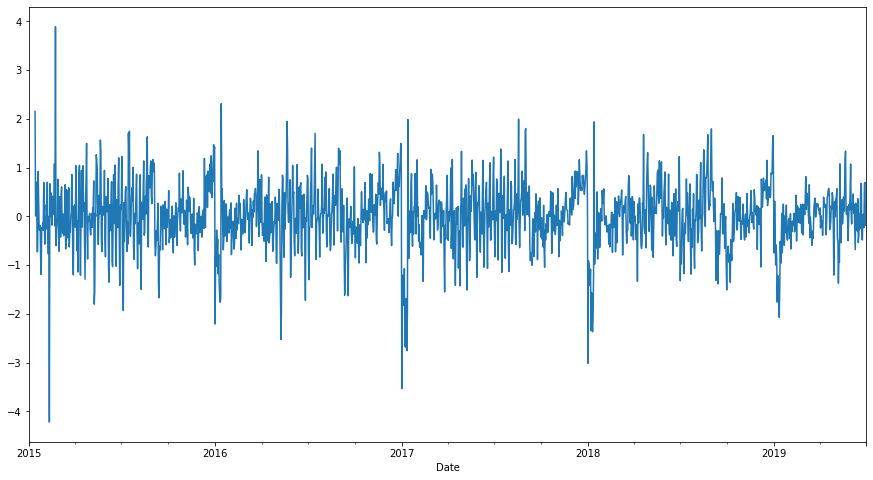

In [80]:
#Дифферинцируем и выводим график
df['series1_box_diff'] = df.series1_box - df.series1_box.shift(12)
df.series1_box_diff.plot()

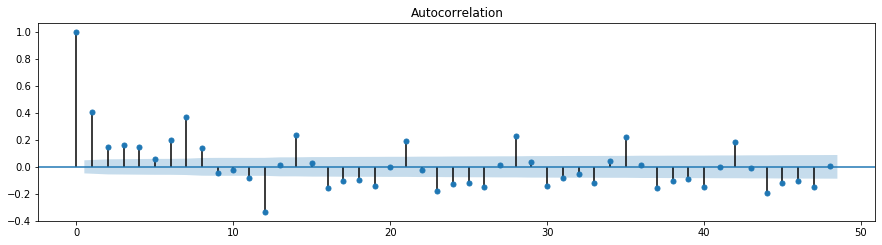

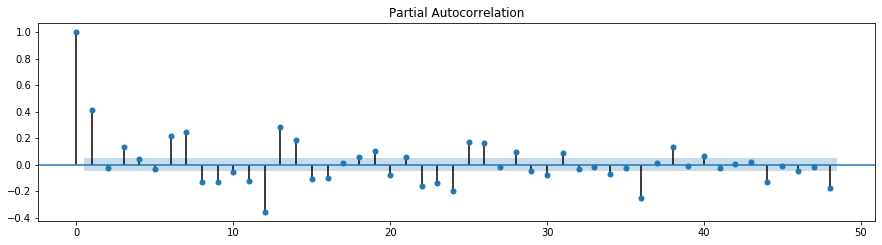

In [57]:
# Снова строим автокорреляцию и частичную автокорреляцию для подбора начальных приближений Q, q, P, p
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.series1_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.series1_box_diff[13:].squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения Q = 2, P = 2, q = 8, p = 7

In [8]:
ps = range(0, 8)
d=1
qs = range(0, 9)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

648

## Строим и оптимизиуем модель SARIMAX, как наиболее подходящую  с учетом присутствия сезонности во временном ряде

In [59]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(df.series1_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████████████████████████████████████████████████████████████████████████| 648/648 [7:23:03<00:00, 41.02s/it]

       parameters          aic
644  (7, 8, 1, 2)  1511.652270
638  (7, 7, 2, 2)  1513.351221
635  (7, 7, 1, 2)  1514.231706
634  (7, 7, 1, 1)  1516.101122
631  (7, 7, 0, 1)  1516.110078
Wall time: 7h 23min 3s


In [60]:
#Лучшая модель 
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                             series1_box   No. Observations:                 1642
Model:             SARIMAX(7, 1, 8)x(1, 1, [1, 2], 12)   Log Likelihood                -736.826
Date:                                 Thu, 06 Aug 2020   AIC                           1511.652
Time:                                         20:26:11   BIC                           1614.171
Sample:                                     01-01-2015   HQIC                          1549.687
                                          - 06-30-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6473      0.181     -3.573      0.000      -1.002      -0

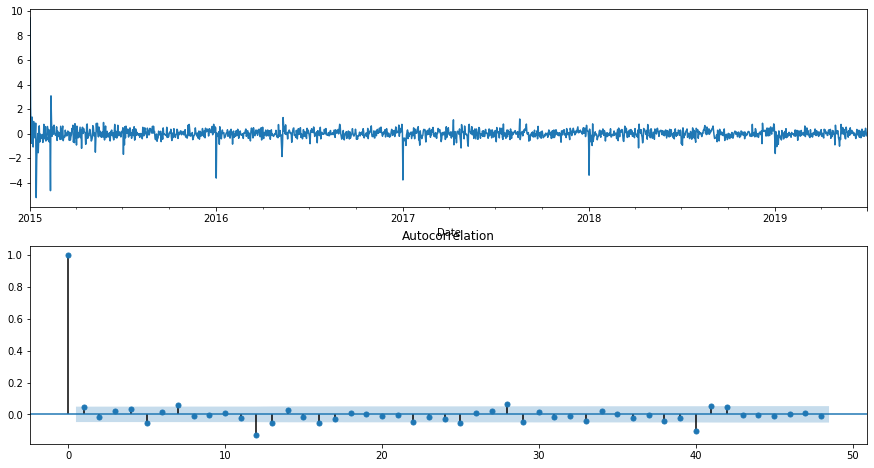

Критерий Стьюдента: p = 0.71912
Критерий Дики-Фуллера: p = 0.00000


In [61]:
#Проверяем остатки
plt.figure(figsize(15, 8))
plt.subplot(211)
best_model.resid.plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=48, ax=ax)
pylab.show()

print(f'Критерий Стьюдента: p = {round(stats.ttest_1samp(best_model.resid, 0)[1], 5)}')
print(f'Критерий Дики-Фуллера: p = {round(Decimal(sm.tsa.stattools.adfuller(best_model.resid)[1]), 5)}')

Остатки несмещены, стационарны и неавтокоррелированы.

## Смотрим насколько хорошо модель описывает данные

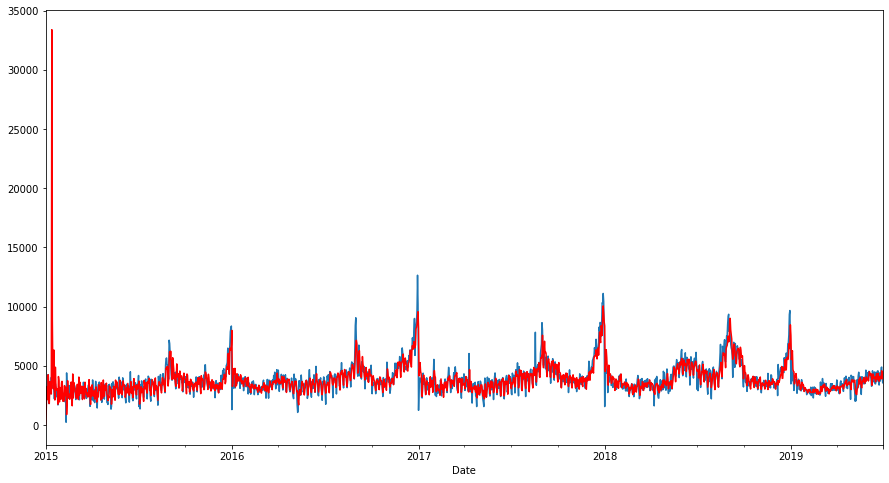

In [85]:
# Функция для обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15, 8))
df.series1.plot()
df.model.plot(color='r')

## Прогноз

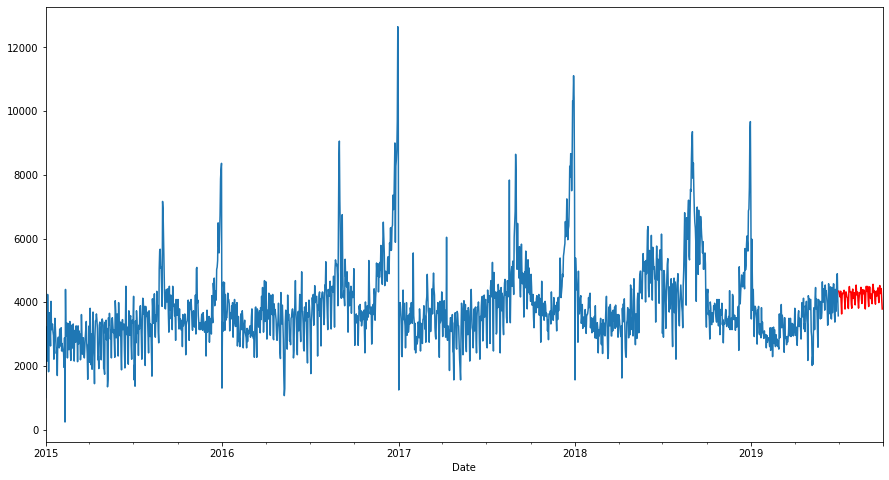

In [79]:
from datetime import date
date_list = list(pd.date_range((date(2019, 7, 1) + pd.DateOffset(days=0)), periods=92, freq='D'))
predict = pd.DataFrame(index=date_list)
predict['predict_values'] = invboxcox(best_model.predict(start=1642, end = 1732), lmbda)
plt.figure(figsize(15, 8))
df.series1.plot()
predict.predict_values.plot(color='r')

In [9]:
predict.head(15)

NameError: name 'predict' is not defined

In [84]:
#Сохраняем спрогнозированные данные в Excel-файл
predict.to_excel('Timeseries_predict.xlsx')